# Tomato Disease Prediction for AgroAI  
## Model 1: Convolutional Neural Network
### Import Dependencies

In [1]:
import tensorflow as tf
from PIL import Image
import cv2, pathlib, splitfolders
from tensorflow.keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
import os
import shutil
import pickle
import tempfile
from sklearn.model_selection import train_test_split

In [2]:
import seaborn as sns

In [3]:
np.__version__

'1.23.5'

In [4]:
tf.__version__

'2.6.0'

In [5]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

Num GPUs Available:  1


### Load Images

In [6]:
IMAGE_SIZE = 256
TARGET_SIZE = (IMAGE_SIZE, IMAGE_SIZE)
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
CHANNELS = 3
BATCH_SIZE = 32
INPUT_SHAPE2 = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

In [7]:
#def get_dataset_partitions_pd(df, train_split=0.8, val_split=0.1, test_split=0.1):
#    assert (train_split + test_split + val_split) == 1
#    
    # Only allows for equal validation and test splits
#    assert val_split == test_split 

In [8]:
# Set up the base directory
base_dir = "./AgroAI/Tomato"

In [9]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
            base_dir,
            labels = 'inferred',
            shuffle = True,
            image_size = (IMAGE_SIZE, IMAGE_SIZE),
            batch_size = BATCH_SIZE,
            color_mode = 'rgb'
)

Found 9119 files belonging to 10 classes.


In [10]:
type(dataset)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [ ]:
#def resize_data(images, labels):
#    tf.print('Original shape -->', tf.shape(images))
#    SIZE = (224, 224)
#    return tf.image.resize(images, SIZE), labels

In [ ]:
#dataset = dataset.map(resize_data)

In [11]:
classes = dataset.class_names
classes

['Tomato Bacterial spot',
 'Tomato Early blight',
 'Tomato Late blight',
 'Tomato Leaf Mold',
 'Tomato Septoria leaf spot',
 'Tomato Spider mites Two spotted spider mite',
 'Tomato Target Spot',
 'Tomato Tomato Yellow Leaf Curl Virus',
 'Tomato Tomato mosaic virus',
 'Tomato healthy']

In [12]:
len(dataset)

285

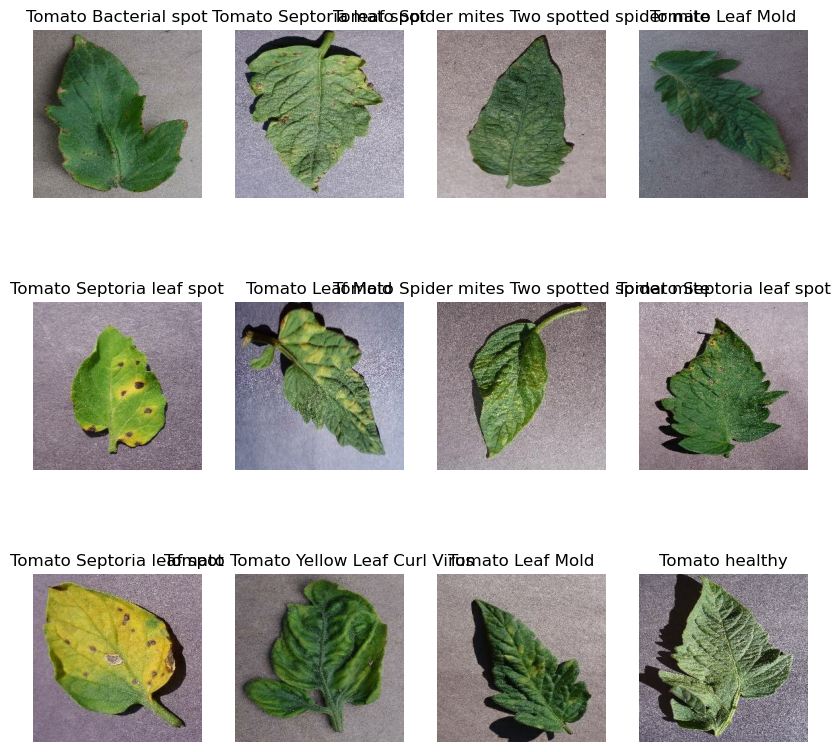

In [13]:
plt.figure(figsize=(10,10))
for image_batch , label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(classes[label_batch[i]])
        plt.axis('off')

In [14]:
len(dataset) * 64

18240

### Data Splitting

In [15]:
def data_split(data, train_split = 0.8, val_split = 0.15, 
               test_split = 0.05, shuffle=True, shuffle_size = 10000):
    data_size = len(data)
    if shuffle:
        data = data.shuffle(shuffle_size, seed=8)
    
    train_size = int(train_split * data_size)
    val_size = int(val_split * data_size)
    
    train_ds = data.take(train_size)
    val_ds = data.skip(train_size).take(val_size)
    test_ds = data.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = data_split(dataset)

In [17]:
print("Length of Training Dataset is",len(train_ds))
print("\nLength of Validation Dataset is",len(val_ds))
print("\nLength of Testing Dataset is",len(test_ds))

Length of Training Dataset is 228

Length of Validation Dataset is 42

Length of Testing Dataset is 15


### Image Augmentation

Since ImageDataGenerator is deprecated as of Tensorflow >=2.5, we can use the Keras Layers Experimental Preprocessing API to apply the image augmentations instead.

In [18]:
train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

<PrefetchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [19]:
resizing_rescaling = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(224,224),
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255.0)
])

In [20]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.4),
    tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(-0.3, 0.3),
                                                                 width_factor=(-0.3, 0.3),
                                                                 fill_mode = 'nearest'),
    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=(-0.3, 0.3),
                                                                 width_factor=(-0.3, 0.3),
                                                                 fill_mode = 'nearest'),
    tf.keras.layers.experimental.preprocessing.RandomHeight(factor=(-0.3, 0.3),
                                                            interpolation = 'nearest'),
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.9)
])

### Init Methods

In [21]:
def conf_matrix(y_test, y_pred):
  cf_matrix = confusion_matrix(y_test, y_pred)

  ax = sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues')

  ax.set_title('Confusion Matrix with labels\n')
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ')
  ax.set_xticks()
  ax.xaxis.set_ticklabels(source_classes, rotation=45)
  ax.yaxis.set_ticklabels(source_classes, rotation=45)

  plt.show()

In [22]:
saved_model_dir = "saved_model"
saved_model_his = "saved_model_history"
tflite_model_dir = "tflite_model"

if not(os.path.isdir(saved_model_dir)): os.mkdir(saved_model_dir)
if not(os.path.isdir(saved_model_his)): os.mkdir(saved_model_his)
if not(os.path.isdir(tflite_model_dir)): os.mkdir(tflite_model_dir)

In [23]:
# save model method
def saved_model(modelname, model):
  export_path = os.path.join(saved_model_dir, modelname)
  if os.path.isdir(export_path):
    print('\nAlready saved a model, replace to new model\n')
    shutil.rmtree(export_path, ignore_errors=True)

  model.save(export_path)
  print("Export path: ", export_path)
  print(os.listdir(export_path))

# save model history method
def saved_model_history(modelname, history):
  with open(os.path.join(saved_model_his, modelname), 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [24]:
# convert saved model to TFLite model
def tflite_model_convert(modelname, tflitedir):
  # Intialize the TFLite converter to load the SavedModel
  export_path = os.path.join(saved_model_dir, modelname)

  converter = tf.lite.TFLiteConverter.from_saved_model(export_path)

  # Set the optimization strategy in the converter 
  converter.optimizations = [tf.lite.Optimize.DEFAULT]

  # Use the tool to finally convert the model
  tflite_model = converter.convert()

  # Write TFLite model
  tflite_dir = os.path.join(tflite_model_dir, tflitedir)

  if os.path.isdir(tflite_dir):
    print('\nAlready saved a model, replace to new model\n')
    shutil.rmtree(tflite_dir, ignore_errors=True)

  os.mkdir(tflite_dir)

  tflite_file = os.path.join(tflite_dir, "leaf_{}.tflite".format(tflitedir.lower()))
  label_file = os.path.join(tflite_dir, "leaf_{}.txt".format(tflitedir.lower()))

  with open(tflite_file, "wb") as f:
      f.write(tflite_model)

  with open(label_file, 'w') as f:
      f.write('\n'.join(name_classes))

  print("Export path: ", tflite_dir)
  print(os.listdir(tflite_dir))

In [25]:
# save all model with simplify function
def save_all_model(modelname, model, history):
  # save model
  saved_model(modelname, model)

  # save history as dict
  saved_model_history(modelname, history)

  # save best model
  #best_model = tf.keras.models.load_model('best_{}.h5'.format(modelname))
  #best_modelname = "BestMC_{}".format(modelname)
  #saved_model(best_modelname, best_model)
  # clear best model h5 format
 # os.remove('best_{}.h5'.format(modelname))

  # save tflite best model
  #tflite_model_convert(best_modelname, modelname)

### Model 1: Convolutional Neural Network

In [44]:
len(classes)

10

In [45]:
n_classes = 10

model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=INPUT_SHAPE),
    resizing_rescaling,
    data_augmentation,
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=(None,) + INPUT_SHAPE)
model.output_shape

(None, 10)

In [46]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, None, 224, 3)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, None, 222, 32)     896       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, None, 111, 32)     0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, None, 109, 32)     9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, None, 54, 32)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, None, 52, 64)     

In [47]:
class EarlyStoppingAtMaxAccuracy(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if(logs.get('accuracy')>=0.99):
            print("\nAccuracy is high so cancelling training!")
            self.model.stop_training = True

callbacks = EarlyStoppingAtMaxAccuracy()

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9)


In [48]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics=['accuracy']
)

In [49]:
#model.compile(
#    optimizer='adam',
#    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
#    metrics=['accuracy']
#)

In [50]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=100,
    callbacks=[callbacks]
)

Epoch 1/100
228/228 [==============================] - 18s 61ms/step - loss: 2.1604 - accuracy: 0.1891 - val_loss: 1.9200 - val_accuracy: 0.3095
Epoch 2/100
228/228 [==============================] - 16s 57ms/step - loss: 1.9353 - accuracy: 0.2765 - val_loss: 1.9239 - val_accuracy: 0.3013
Epoch 3/100
228/228 [==============================] - 17s 62ms/step - loss: 1.7278 - accuracy: 0.3542 - val_loss: 2.0309 - val_accuracy: 0.3006
Epoch 4/100
228/228 [==============================] - 16s 59ms/step - loss: 1.6260 - accuracy: 0.3904 - val_loss: 1.5424 - val_accuracy: 0.4293
Epoch 5/100
228/228 [==============================] - 16s 61ms/step - loss: 1.5386 - accuracy: 0.4315 - val_loss: 1.6862 - val_accuracy: 0.4643
Epoch 6/100
228/228 [==============================] - 16s 58ms/step - loss: 1.4508 - accuracy: 0.4648 - val_loss: 1.5103 - val_accuracy: 0.5089
Epoch 7/100
228/228 [==============================] - 17s 62ms/step - loss: 1.3270 - accuracy: 0.5208 - val_loss: 1.1197 - val_ac

In [67]:
model.save('CNNModel_Tomato_v1.h5')

In [68]:
modelname = "CNNModel_Tomato_Save1"
save_all_model(modelname, model, history)

INFO:tensorflow:Assets written to: saved_model\CNNModel_Tomato_Save1\assets
Export path:  saved_model\CNNModel_Tomato_Save1
['assets', 'keras_metadata.pb', 'saved_model.pb', 'variables']


In [51]:
score_train = model.evaluate(train_ds)
score_valid = model.evaluate(val_ds)
score_test = model.evaluate(test_ds)

15/15 [==============================] - 3s 17ms/step - loss: 0.1484 - accuracy: 0.9479


In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [53]:
print("Accuracy: {}".format(acc[-1]))
print("Validation Accuracy: {}".format(val_acc[-1]))

print("Loss: {}".format(loss[-1]))
print("Validation Loss: {}".format(val_loss[-1]))

Accuracy: 0.9087170958518982
Validation Accuracy: 0.9627699255943298
Loss: 0.2536027133464813
Validation Loss: 0.11370857805013657


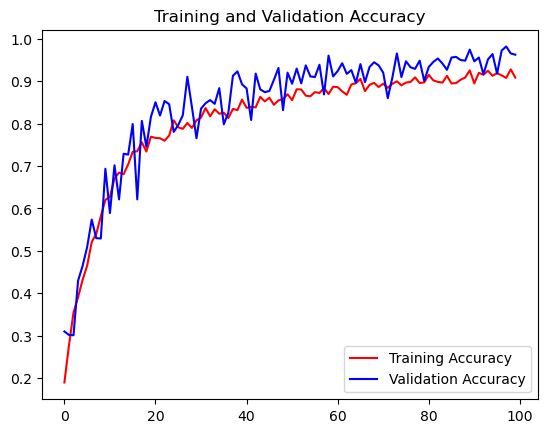

<Figure size 640x480 with 0 Axes>

In [54]:
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

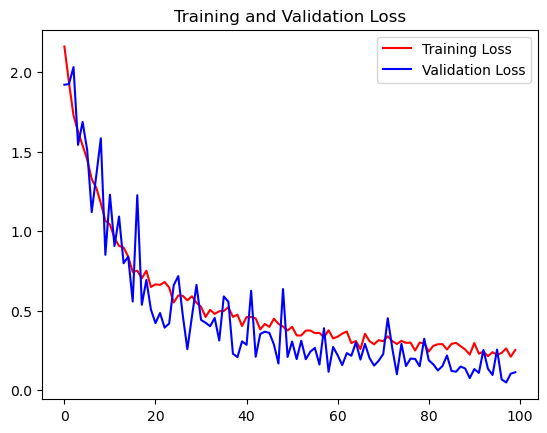

<Figure size 640x480 with 0 Axes>

In [55]:
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc=0)
plt.figure()

plt.show()

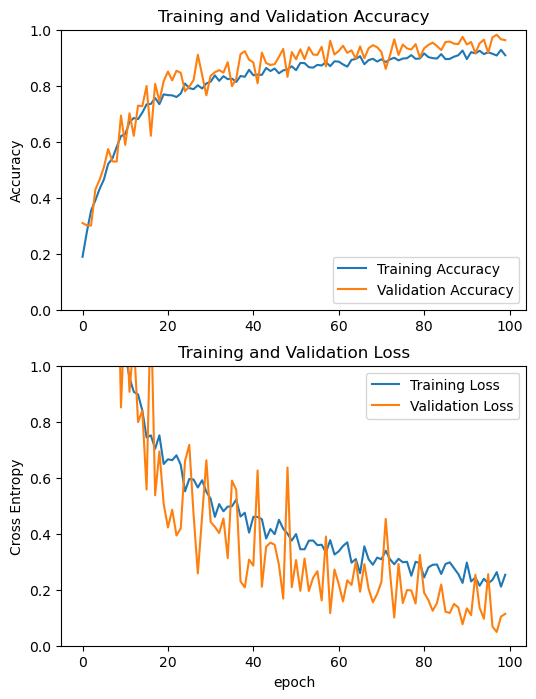

In [56]:
plt.figure(figsize=(6, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
#plt.ylim([min(plt.ylim()),1])
plt.ylim([0,1.0])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

first image to predict
actual label: Tomato Late blight
predicted label: Tomato Late blight


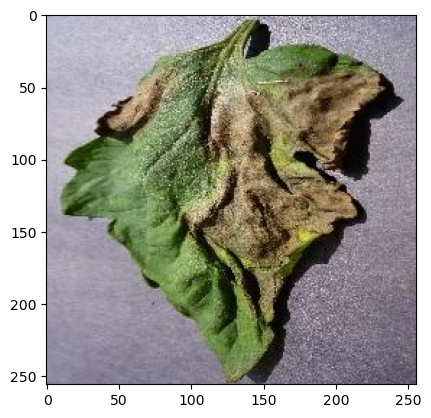

In [57]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",classes[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",classes[np.argmax(batch_prediction[0])])

In [58]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict (img_array)
    predicted_class = classes[np.argmax(predictions[0])]
#     confidence = round(np.max(predictions[0]),2)
    confidence = round(100*(np.max(predictions[0])),2)

    return predicted_class, confidence

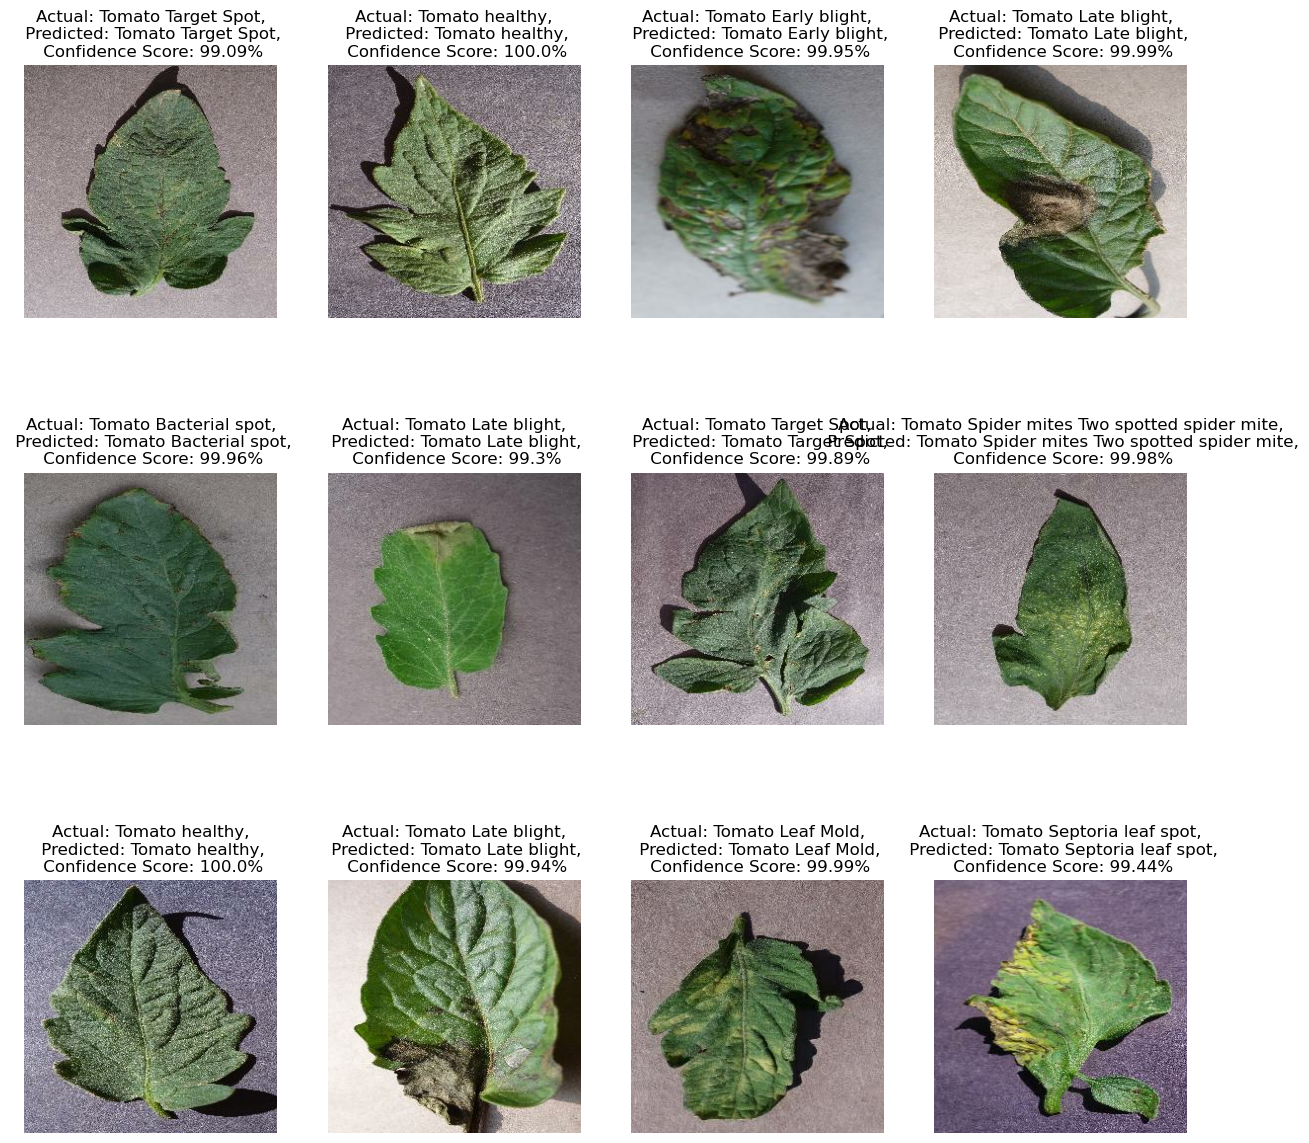

In [59]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class , confidence = predict(model,images[i].numpy())
        actual_class = classes[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence Score: {confidence}%")
        plt.axis("off")

In [60]:
pred_class = []
act_class = []
for images,labels in test_ds:
    for i in range(len(test_ds)):
        #ax = plt.subplot(3,4,i+1)
        #plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class , confidence = predict(model,images[i].numpy())
        actual_class = classes[labels[i]]

        pred_class.append(predicted_class)
        act_class.append(actual_class)

In [61]:
act_class

['Tomato Late blight',
 'Tomato Septoria leaf spot',
 'Tomato Target Spot',
 'Tomato Tomato Yellow Leaf Curl Virus',
 'Tomato Bacterial spot',
 'Tomato healthy',
 'Tomato Tomato mosaic virus',
 'Tomato Tomato Yellow Leaf Curl Virus',
 'Tomato Tomato mosaic virus',
 'Tomato Late blight',
 'Tomato healthy',
 'Tomato Leaf Mold',
 'Tomato Target Spot',
 'Tomato Early blight',
 'Tomato Tomato Yellow Leaf Curl Virus',
 'Tomato Tomato Yellow Leaf Curl Virus',
 'Tomato Target Spot',
 'Tomato Tomato Yellow Leaf Curl Virus',
 'Tomato Tomato Yellow Leaf Curl Virus',
 'Tomato Late blight',
 'Tomato healthy',
 'Tomato Tomato Yellow Leaf Curl Virus',
 'Tomato Spider mites Two spotted spider mite',
 'Tomato Tomato Yellow Leaf Curl Virus',
 'Tomato Late blight',
 'Tomato Late blight',
 'Tomato Leaf Mold',
 'Tomato Leaf Mold',
 'Tomato Tomato mosaic virus',
 'Tomato healthy',
 'Tomato Early blight',
 'Tomato Target Spot',
 'Tomato Late blight',
 'Tomato Late blight',
 'Tomato Early blight',
 'Tomato To

In [62]:
cm = confusion_matrix(act_class, pred_class, labels=classes)

In [65]:
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(16,5))
    ax = sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    ax.set_title('Confusion Matrix with labels\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ax.xaxis.set_ticklabels(classes, rotation=45)
    ax.yaxis.set_ticklabels(classes, rotation=45)

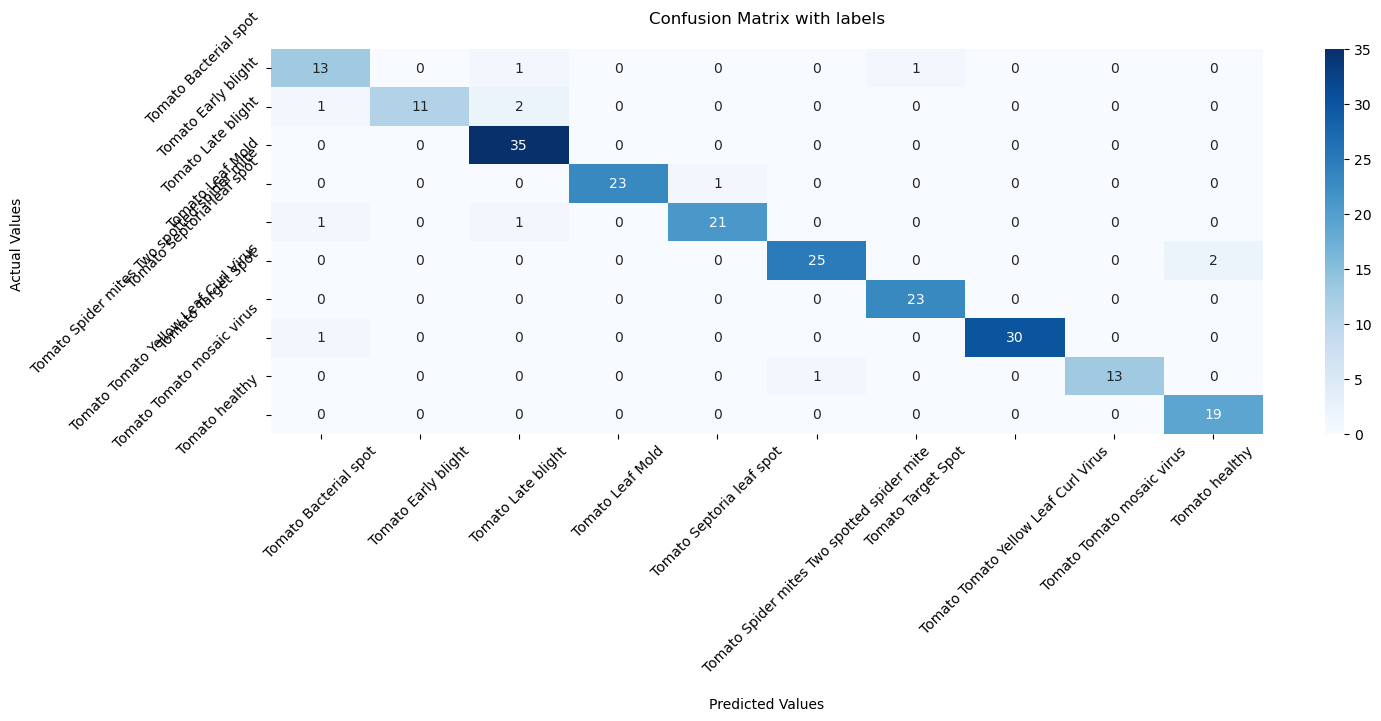

In [66]:
plot_confusion_matrix(cm = cm, classes = classes)

### Model 2: MobileNet

In [ ]:
def prepare_image(file)

In [115]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 

mbnet_v2 = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3),
    pooling='avg'
)


mbnet_v2.trainable = False

In [116]:
mbnet_v2.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_19[0][0]                   
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [78]:
#resizing_rescaling2 = tf.keras.Sequential([
#    tf.keras.layers.experimental.preprocessing.Resizing(256,256),
#    tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255.0)
#])

In [117]:
n_classes = 10
model2 = tf.keras.models.Sequential([
    #tf.keras.layers.InputLayer(input_shape=(224, 224, 3)),  # Update the input shape here
    resizing_rescaling,
    data_augmentation,
    mbnet_v2,
    tf.keras.layers.Dropout(0.4),
    #tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(n_classes, activation='softmax')  
])

model2.build(input_shape=(None,) + (224, 224, 3))  # Update the input shape here
model2.output_shape

(None, 10)

In [118]:
model2.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, None, None, 3)     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
dropout_24 (Dropout)         (None, 1280)              0         
_________________________________________________________________
dense_45 (Dense)             (None, 512)               655872    
_________________________________________________________________
dropout_25 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 256)             

In [119]:
model2.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

In [120]:
history2 = model2.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
    callbacks=[callbacks] 
)

Epoch 1/50


ValueError: in user code:

    c:\Users\marie\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py:853 train_function  *
        return step_function(self, iterator)
    c:\Users\marie\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\Users\marie\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\Users\marie\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\Users\marie\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\Users\marie\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py:835 run_step  **
        outputs = model.train_step(data)
    c:\Users\marie\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py:788 train_step
        loss = self.compiled_loss(
    c:\Users\marie\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\compile_utils.py:201 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    c:\Users\marie\anaconda3\envs\tensorflow\lib\site-packages\keras\losses.py:141 __call__
        losses = call_fn(y_true, y_pred)
    c:\Users\marie\anaconda3\envs\tensorflow\lib\site-packages\keras\losses.py:245 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    c:\Users\marie\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    c:\Users\marie\anaconda3\envs\tensorflow\lib\site-packages\keras\losses.py:1665 categorical_crossentropy
        return backend.categorical_crossentropy(
    c:\Users\marie\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    c:\Users\marie\anaconda3\envs\tensorflow\lib\site-packages\keras\backend.py:4839 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    c:\Users\marie\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\tensor_shape.py:1161 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 1) and (None, 10) are incompatible


### Model 3: InceptionV3

In [ ]:

from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(input_shape=img_shape,
                                include_top=False,
                                weights='imagenet')

for layer in pre_trained_model.layers:
  layer.trainable = True

pre_trained_model.summary()